In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime as dt
import joblib

## Import CSVs

In [3]:
lstm_pred = pd.read_pickle('lstm_result.pickle')
lstm_pred

,actual,y_pred_LSTM
Date,,
2021-01-04,128.189713,37.250351
2021-01-05,128.010849,37.244179
2021-01-06,130.088043,36.586369
2021-01-07,128.120163,37.019730
2021-01-08,126.361008,37.626160
...,...,...
2021-12-17,180.330002,120.968719
2021-12-20,179.289993,119.670441
2021-12-21,179.380005,117.874374


In [4]:
rf_pred = pd.read_csv('csv/rf_random.csv', index_col=0)
# arima_pred = pd.read_csv('csv/arima.csv', index_col=0)
# lstm_pred = pd.read_csv('csv/lstm_pred.csv', index_col=0)

## Format rf_pred

In [5]:
rf_pred.index = pd.to_datetime(rf_pred.index)

In [6]:
rf_pred.drop(columns='Residual', inplace=True)
rf_pred

,Actual,RF_pred
Date,,
2021-01-04,128.189713,133.982366
2021-01-05,128.010849,130.505458
2021-01-06,130.088043,133.982366
2021-01-07,128.120163,129.519951
2021-01-08,126.361008,130.012704
...,...,...
2021-12-17,180.330002,133.170698
2021-12-20,179.289993,130.012704
2021-12-21,179.380005,130.992063


## Format lstm_pred

In [7]:
lstm_pred.index = pd.to_datetime(lstm_pred.index)

In [8]:
lstm_pred.drop(columns='actual', inplace=True)

In [9]:
lstm_pred

,y_pred_LSTM
Date,
2021-01-04,37.250351
2021-01-05,37.244179
2021-01-06,36.586369
2021-01-07,37.019730
2021-01-08,37.626160
...,...
2021-12-17,120.968719
2021-12-20,119.670441
2021-12-21,117.874374


In [10]:
lstm_pred.rename(columns={'y_pred_LSTM':'LSTM_pred'}, inplace=True)
lstm_pred

,LSTM_pred
Date,
2021-01-04,37.250351
2021-01-05,37.244179
2021-01-06,36.586369
2021-01-07,37.019730
2021-01-08,37.626160
...,...
2021-12-17,120.968719
2021-12-20,119.670441
2021-12-21,117.874374


## Combine all dfs

In [11]:
comb_df = rf_pred.merge(lstm_pred, left_on='Date', right_on='Date')
comb_df

,Actual,RF_pred,LSTM_pred
Date,,,
2021-01-04,128.189713,133.982366,37.250351
2021-01-05,128.010849,130.505458,37.244179
2021-01-06,130.088043,133.982366,36.586369
2021-01-07,128.120163,129.519951,37.019730
2021-01-08,126.361008,130.012704,37.626160
...,...,...,...
2021-12-17,180.330002,133.170698,120.968719
2021-12-20,179.289993,130.012704,119.670441
2021-12-21,179.380005,130.992063,117.874374


## Splitting the Data 

In [12]:
train_length = len(comb_df)*0.8
test_length = len(comb_df)*0.2

In [13]:
X_train = comb_df[['RF_pred','LSTM_pred']][0:int(train_length)]
y_train = comb_df['Actual'][0:int(train_length)]
X_test = comb_df[['RF_pred','LSTM_pred']][int(train_length):]
y_test = comb_df['Actual'][int(train_length):]

## Fit linear model

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
joblib.dump(model, 'rf_lstm_linear.joblib')

['rf_lstm_linear.joblib']

In [16]:
model.score(X_test, y_test)

0.37646645354331354

In [17]:
y_pred = model.predict(X_test)

In [18]:
metrics.mean_absolute_error(y_test, y_pred)

7.59836497886138

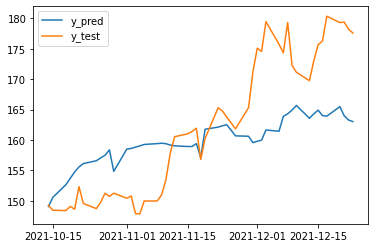

In [19]:
plt.plot(y_test.index, y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend()

## format arima

In [25]:
arima_pred = pd.read_csv('csv/arima.csv', index_col=0)
arima_pred.index = pd.to_datetime(arima_pred.index)
arima_pred = arima_pred.drop(columns='y_actual')
arima_pred.columns = ['ARIMA_pred']
arima_pred

,ARIMA_pred
Date,
2021-01-04,128.333703
2021-01-05,129.454595
2021-01-06,122.907843
2021-01-07,130.062883
2021-01-08,133.188385
...,...
2021-12-17,164.255411
2021-12-20,163.700089
2021-12-21,167.684540


## With arima

In [26]:
comb3_df = comb_df.join(arima_pred)
comb3_df

,Actual,RF_pred,LSTM_pred,ARIMA_pred
Date,,,,
2021-01-04,128.189713,133.982366,37.250351,128.333703
2021-01-05,128.010849,130.505458,37.244179,129.454595
2021-01-06,130.088043,133.982366,36.586369,122.907843
2021-01-07,128.120163,129.519951,37.019730,130.062883
2021-01-08,126.361008,130.012704,37.626160,133.188385
...,...,...,...,...
2021-12-17,180.330002,133.170698,120.968719,164.255411
2021-12-20,179.289993,130.012704,119.670441,163.700089
2021-12-21,179.380005,130.992063,117.874374,167.684540


In [33]:
X3_train = comb3_df[['RF_pred','LSTM_pred','ARIMA_pred']][0:int(train_length)]
X3_test = comb3_df[['RF_pred','LSTM_pred','ARIMA_pred']][int(train_length):]


In [34]:
model3 = LinearRegression()
model3.fit(X3_train, y_train)

LinearRegression()

In [35]:
model3.score(X3_test, y_test)

0.3570590370694525

In [36]:
y3_pred = model3.predict(X3_test)

In [37]:
metrics.mean_absolute_error(y_test, y3_pred)

7.028217128620859

## without RF

In [40]:
X4_train = comb3_df[['LSTM_pred','ARIMA_pred']][0:int(train_length)]
X4_test = comb3_df[['LSTM_pred','ARIMA_pred']][int(train_length):]


In [41]:
model4 = LinearRegression()
model4.fit(X4_train, y_train)
model4.score(X4_test, y_test)

0.35623002116312596

In [43]:
y4_pred = model4.predict(X4_test)
metrics.mean_absolute_error(y_test, y4_pred)

7.025184745227412

## without LSTM

In [44]:
X5_train = comb3_df[['RF_pred','ARIMA_pred']][0:int(train_length)]
X5_test = comb3_df[['RF_pred','ARIMA_pred']][int(train_length):]

In [47]:
model5 = LinearRegression()
model5.fit(X5_train, y_train)
model5.score(X5_test, y_test)

# does not work

-0.029233822007779908

## Get graphs

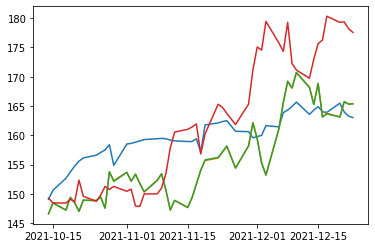

In [61]:
plt.plot(y_test.index, y_pred, label='RF_LSTM_pred')
plt.plot(y_test.index, y3_pred, label='RF_LSTM_ARIMA_pred')
plt.plot(y_test.index, y4_pred, label='LSTM_ARIMA_pred')
plt.plot(y_test.index, y_test, label='y_test')
# plt.legend()

## Individual graphs

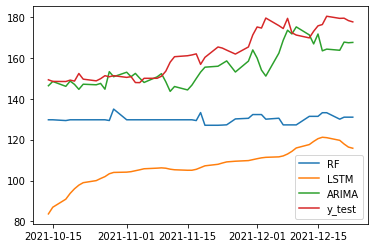

In [59]:
plt.plot(y_test.index, comb3_df['RF_pred'][int(train_length):], label='RF')
plt.plot(y_test.index, comb3_df['LSTM_pred'][int(train_length):], label='LSTM')
plt.plot(y_test.index,comb3_df['ARIMA_pred'][int(train_length):], label='ARIMA')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend()

In [60]:
print(metrics.mean_absolute_error(y_test, comb3_df['ARIMA_pred'][int(train_length):]))

7.169204970496094


## Elastic Net CV

In [51]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

### No Arima

In [55]:
for n in range(3, 11):
    cv = TimeSeriesSplit(n_splits=n)
    cv.split(X_train)
    regr = ElasticNetCV(cv=cv, random_state=0)
    regr.fit(X_train, y_train)
    print(f'{n}: {regr.score(X_test, y_test)}, {metrics.mean_absolute_error(y_test, regr.predict(X_test))}')
    


3: 0.08192384728379887, 8.831810580369256
4: -0.23002517895545482, 9.8348468854995
5: 0.3057913516012819, 8.025940373074919
6: 0.20219131999593243, 8.404151422880954
7: 0.11101065792575804, 8.72757963741996
8: 0.25051141659334464, 8.232638320978605
9: 0.13731663475601563, 8.63537144797909
10: 0.3140797049039735, 7.992204374340774


### all3

In [56]:
for n in range(3, 11):
    cv = TimeSeriesSplit(n_splits=n)
    cv.split(X3_train)
    regr = ElasticNetCV(cv=cv, random_state=0)
    regr.fit(X3_train, y_train)
    print(f'{n}: {regr.score(X3_test, y_test)}, {metrics.mean_absolute_error(y_test, regr.predict(X3_test))}')

3: 0.30069569964780596, 7.42335216263612
4: 0.3254311081208925, 7.26015384848996
5: 0.31668979326085644, 7.31968859943573
6: 0.3093916179123867, 7.367706769314647
7: 0.33008877222609334, 7.227372109472952
8: 0.3132077323143869, 7.342773406864792
9: 0.3254311081208925, 7.26015384848996
10: 0.31668979326085644, 7.31968859943573


In [ ]:
reg_y_pred = reg.predict(X_test_na)

In [ ]:
metrics.mean_absolute_error(y_test, reg_y_pred)

In [ ]:
plt.plot(y_test.index, reg_y_pred, label='y_pred')
plt.plot(y_test.index, y_test, label='y_test')
plt.legend();